In [1]:
import os
currentdir = os.path.dirname(os.path.abspath(os.getcwd()))

import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 1})

In [88]:
def plot_eigenvalues(eigvals):
    plt.figure(figsize=(3, 3))
    plt.scatter(np.real(eigvals), np.imag(eigvals))
    plt.xlim([-1.1,1.1])
    plt.ylim([-1.1,1.1])
    plt.xlabel(r"Re($\lambda$)")
    plt.ylabel(r"Im($\lambda$)");

In [3]:
tau = .1
dt = .01
N = 3

def simulate_network(W, T, a_weights, x):
    N = W.shape[0]
    r = np.zeros(N) #initial state
    all_r = np.zeros((T,N))
    for t in range(T):
        r += ((-r + r @ W)*dt)/tau + np.multiply(a_weights, x[t])
        all_r[t,:] = r
    return all_r


T = int(10/dt)
times = np.arange(T)*dt

In [4]:
#input: a_i represents the strength of the external input to unit i
a_weights = np.zeros(N)
a_weights[0] = 1.

#input x(t)
x = np.zeros(T)
x[0] = 1

#connectivity matrix: feedforward network
W = np.diag(np.ones((1, N-1))[0], 1)
W

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 0.]])

In [5]:
I = 1
all_r = simulate_network(W, T, a_weights, I*x)
output_weights =  np.ones(N)
weighted_sum = np.dot(all_r, output_weights)

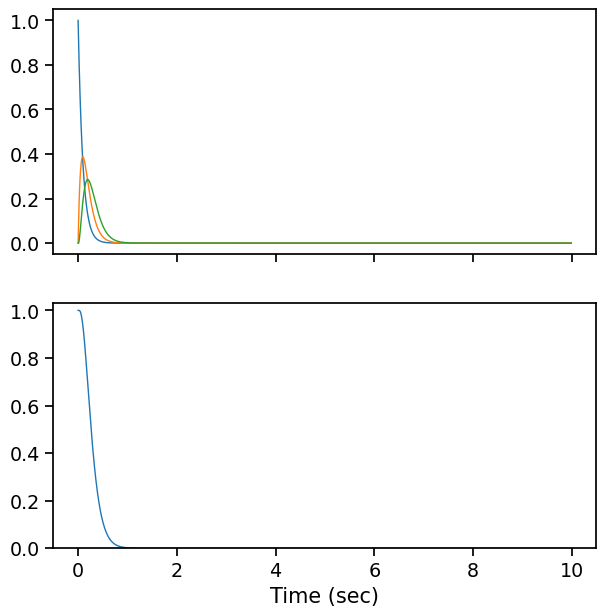

In [6]:
#Figure 1B
fig, axs = plt.subplots(2, 1, figsize=(7, 7), sharex=True)
axs[0].plot(times, all_r)
    
axs[1].plot(times, weighted_sum)
axs[1].set_ylim([0,I*1.03])
plt.xlabel("Time (sec)");
plt.ylabel("");

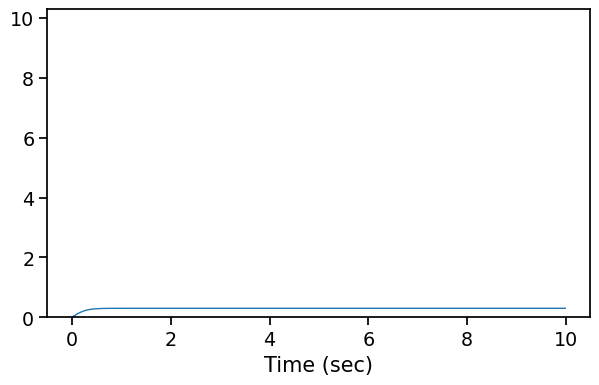

In [7]:
#Figure 1E
# step input leads to a linear ramping output with slope proportional to the size of the step
I= .01
x = np.ones(T)
all_r = simulate_network(W, T, a_weights, I*x)
output_weights =  np.ones(N)
weighted_sum = np.dot(all_r, output_weights)

fig, ax = plt.subplots(1, 1, figsize=(7, 4), sharex=True)

ax.plot(times, weighted_sum)
ax.set_ylim([0,10*1.03])
plt.xlabel("Time (sec)");
plt.ylabel("");

### Feedforward Processing of Inputs by a Recurrent Network

In [158]:
#Feedforward function of feedforward and recurrent networks
#random orthogonal network 
N=3
random_vecs = np.random.randn(N, N)
U, R = np.linalg.qr(random_vecs)

#feedforward connectivity 
T_matrix = np.diag(np.ones((1, N-1))[0], 1)
W = U @ T_matrix @ np.linalg.inv(U)

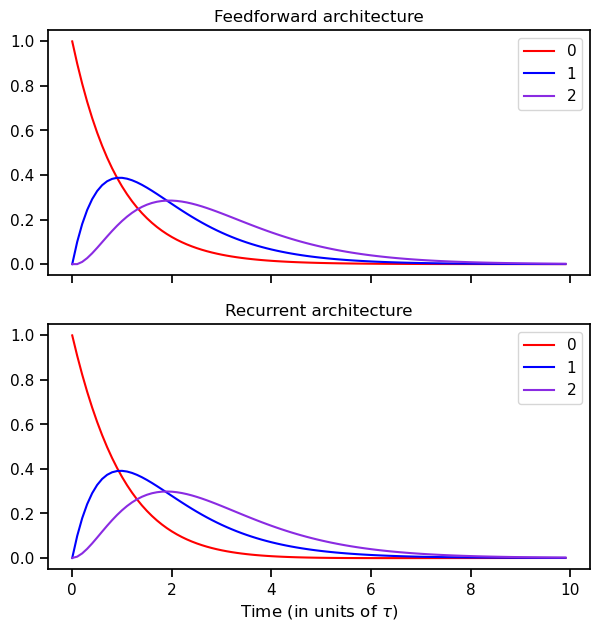

In [159]:
T = int(1/dt)
times = np.arange(T)*tau
x = np.zeros(T)
x[0] = 1
a_weights = np.zeros(N)
a_weights[0] = 1.
all_r_ff = simulate_network(T_matrix, T, a_weights, x) 

a_weights = np.linalg.inv(U) @ a_weights
all_r_rec = simulate_network(W, T, a_weights, x) @ np.linalg.inv(U)

fig, axs = plt.subplots(2,1,  figsize=(7, 7), sharex=True)
colors = ['red', 'blue', 'blueviolet']
for i in range(N):
    axs[0].plot(times, all_r_ff[:,i], c=colors[i], label=i)
    axs[1].plot(times, all_r_rec[:,i], c=colors[i], label=i)
axs[0].set_title("Feedforward architecture")
axs[1].set_title("Recurrent architecture")
plt.xlabel(r"Time (in units of $\tau$)");
axs[0].legend();
axs[1].legend();

### Schur, but Not Eigenvector, Decomposition Reveals Feedforward Interactions between Patterns of Activity

In [192]:
N = 2
W_pure = np.ones((N,N))/2.

W_fff = np.array([[1,1],[-1,-1]])/2. #functionally feedforward

W_mixed = np.array([[1/2.,1/2.],[-1/3.,-1/3.]])

weight_list = [W_pure, W_fff, W_mixed]
label_list = ["Pure\nfeedback", "Functionally\nfeedforward", "Mixed"]

a_weights = np.zeros(N)
a_weights[0] = 1.

output_weights =  np.ones(N)

T = int(.5/dt)
times = np.arange(T)*tau
I = 2
x = np.zeros(T)
x[0] = 1

Text(0, 0.5, 'Neural \n response')

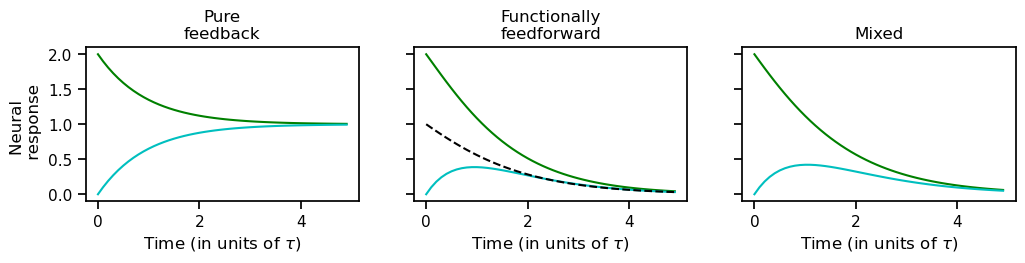

In [193]:
fig, axs = plt.subplots(1, 3, figsize=(12, 2), sharey=True)
for i, W in enumerate(weight_list):
    all_r = simulate_network(W, T, a_weights, I*x)
    
    axs[i].plot(times, all_r[:,0], '-g', times, all_r[:,1], '-c')
    axs[i].set_xlabel(r"Time (in units of $\tau$)")
    axs[i].set_title(label_list[i])
all_r = simulate_network(W, T, a_weights, x)
axs[1].plot(times, all_r[:,0], '--k')
axs[0].set_ylabel("Neural \n response")

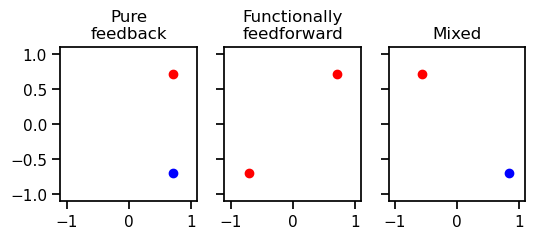

In [236]:
fig, axs = plt.subplots(1, 3, figsize=(6, 2), sharey=True)
# assign colormap
colormap = np.array(['blue', 'red'])
for i, W in enumerate(weight_list):
    eigvals, eigvecs = np.linalg.eig(W)
    for eigval, eigvec in zip(eigvals, eigvecs):
        eignorm = np.linalg.norm(eigval)
        im = axs[i].scatter(eigvec[0], eigvec[1], c=colormap[np.where(np.around(eignorm, 10)>0,0,1)])
    # axs[i].scatter(np.real(eigvals), np.imag(eigvals))
    axs[i].set_xlim([-1.1,1.1])
    axs[i].set_ylim([-1.1,1.1])
    # axs[i].set_xlabel(r"Re($\lambda$)")
    axs[i].set_title(label_list[i])
# plt.colorbar()
# axs[0].set_ylabel(r"Im($\lambda$)");

Text(0, 0.5, 'Neural \n response')

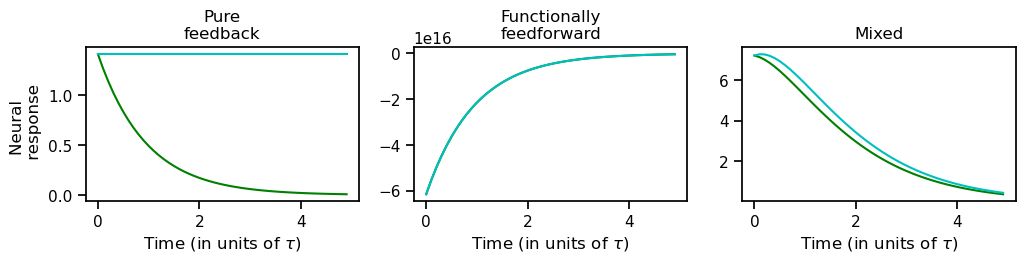

In [237]:
#degenerate eigenvectors: inverse V does not exist (but python doesn't know)
fig, axs = plt.subplots(1, 3, figsize=(12, 2))
for i, W in enumerate(weight_list):
    eigvals, eigvecs = np.linalg.eig(W)
    all_r = simulate_network(W, T, a_weights, I*x) @ np.linalg.inv(np.real(eigvecs))
    
    axs[i].plot(times, all_r[:,0], '-g', times, all_r[:,1], '-c')
    axs[i].set_xlabel(r"Time (in units of $\tau$)")
    axs[i].set_title(label_list[i])
all_r = simulate_network(W, T, a_weights, x)
axs[0].set_ylabel("Neural \n response")

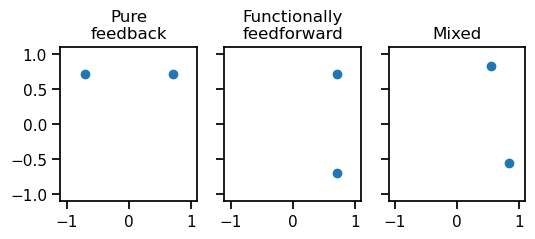

In [238]:

fig, axs = plt.subplots(1, 3, figsize=(6, 2), sharey=True)
for i, W in enumerate(weight_list):
    T_mat, U = scipy.linalg.schur(W)
    axs[i].scatter(*np.real(U))
    axs[i].set_xlim([-1.1,1.1])
    axs[i].set_ylim([-1.1,1.1])
    axs[i].set_title(label_list[i])
# axs[0].set_ylabel(r"Im($\lambda$)");

Text(0, 0.5, 'Neural \n response')

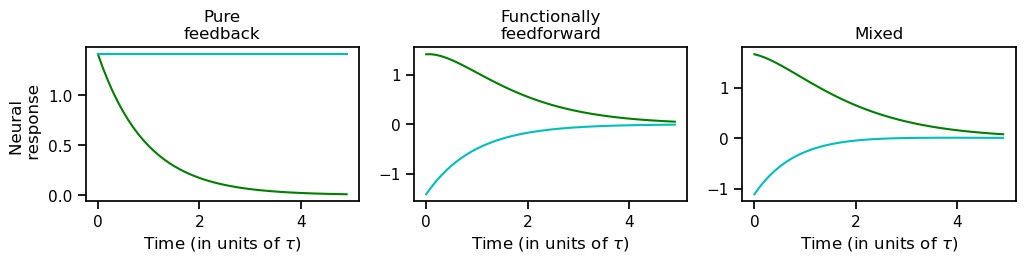

In [199]:
#schur: sure!
fig, axs = plt.subplots(1, 3, figsize=(12, 2))
for i, W in enumerate(weight_list):
    T_mat, U = scipy.linalg.schur(W)
    all_r = simulate_network(W, T, a_weights, I*x) @ np.linalg.inv(np.real(U))
    
    axs[i].plot(times, all_r[:,0], '-g', times, all_r[:,1], '-c')
    axs[i].set_xlabel(r"Time (in units of $\tau$)")
    axs[i].set_title(label_list[i])
axs[0].set_ylabel("Neural \n response")

#### Some additional networks

In [14]:
#cyclic network
T = int(10/dt)
times = np.arange(T)*dt

W = np.diag(np.ones((1, N-1))[0], -1) #(feedfoward + one connection last to first unit)
W[0,-1] = 1.

a_weights = np.zeros(N)
a_weights[0] = 1.

I = 1
x = np.zeros(T)
x[0] = 1
all_r = simulate_network(W, T, a_weights, I*x)
output_weights =  np.ones(N)
weighted_sum = np.dot(all_r, output_weights)

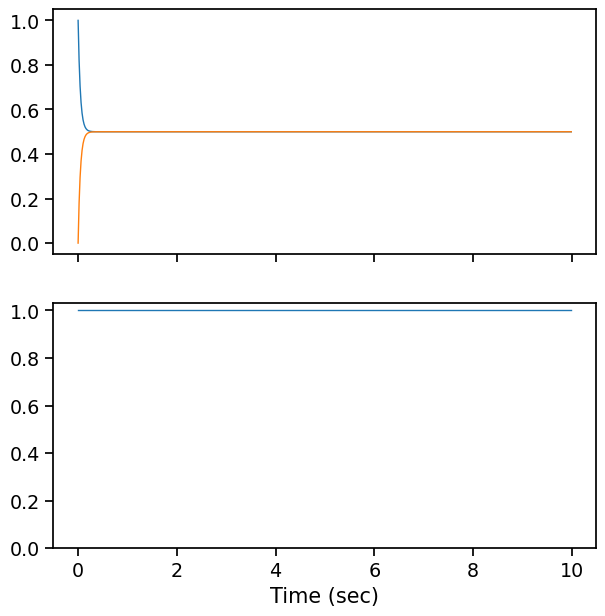

In [15]:
#Figure 
fig, axs = plt.subplots(2, 1, figsize=(7, 7), sharex=True)
axs[0].plot(times, all_r)
axs[1].plot(times, weighted_sum)
axs[1].set_ylim([0,I*1.03])
plt.xlabel("Time (sec)");
plt.ylabel("");

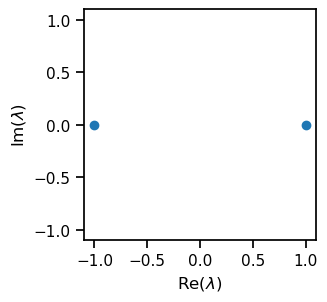

In [16]:
sns.set_context("notebook", font_scale=1.)
eigvals, eigvecs = np.linalg.eig(W)
plot_eigenvalues(eigvals);

In [17]:
#random Gaussian network 
W = np.random.normal(N, N)

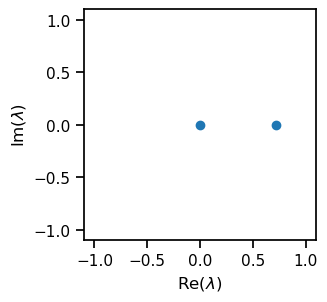

In [18]:
#line attractor (low-rank network)
N=2
a = np.random.randn(N)
b = np.random.randn(N)
a /= np.linalg.norm(a)
b /= np.linalg.norm(b)
# a, b = (a,b)/np.sqrt(np.inner(a,b))
W = np.outer(a, b)

eigvals, eigvecs = np.linalg.eig(W)
plot_eigenvalues(eigvals)
# plt.figure(figsize=(3, 3))
# plt.scatter(eigvals, np.imag(eigvals))
# plt.xlabel(r"Re($\lambda$)")
# plt.ylabel(r"Im($\lambda$)");s

In [19]:
x = np.zeros(T)
x[0] = 1
a_weights = np.zeros(N)
a_weights[0] = 1.

all_r = simulate_network(W, T, a_weights, I*x)
output_weights =  np.ones(N)
weighted_sum = np.dot(all_r, output_weights)

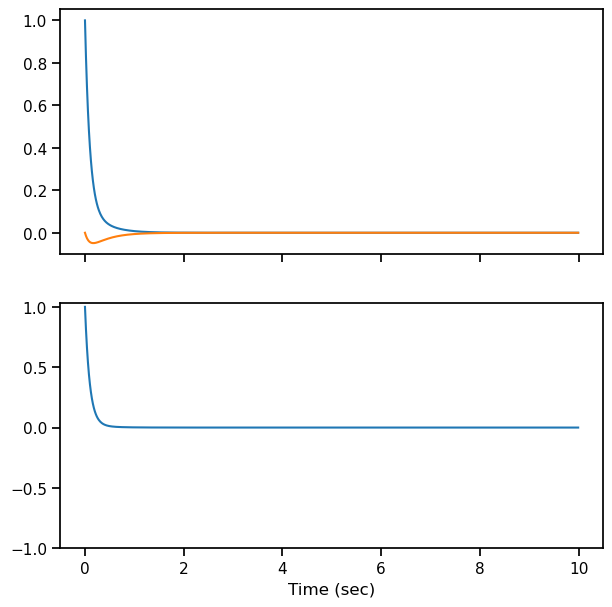

In [20]:
#Figure 
fig, axs = plt.subplots(2, 1, figsize=(7, 7), sharex=True)
axs[0].plot(times, all_r)
axs[1].plot(times, weighted_sum)
axs[1].set_ylim([-1,1.03])
plt.xlabel("Time (sec)");
plt.ylabel("");